In [ ]:
import os

os.listdir('/content')

['.config', 'sample_data']

In [ ]:
import os

file_path = '/multi_chrom_dataset_seq201.npz'

if os.path.exists(file_path):
    print("File exists!")
    print("Size:", os.path.getsize(file_path), "bytes")
else:
    print("File NOT found!")


File exists!
Size: 51343447 bytes


In [ ]:
!ls -al /


total 50604
drwxr-xr-x   1 root root     4096 Nov 19 16:08 .
drwxr-xr-x   1 root root     4096 Nov 19 16:08 ..
lrwxrwxrwx   1 root root        7 Jun 27  2024 bin -> usr/bin
drwxr-xr-x   2 root root     4096 Apr 18  2022 boot
drwxr-xr-x   1 root root     4096 Nov 17 14:29 content
-rw-r--r--   1 root root     4332 Jul 10  2024 cuda-keyring_1.1-1_all.deb
drwxr-xr-x   1 root root     4096 Nov 17 14:38 datalab
drwxr-xr-x   6 root root      460 Nov 19 16:07 dev
-rwxr-xr-x   1 root root        0 Nov 19 16:07 .dockerenv
drwxr-xr-x   1 root root     4096 Nov 19 16:07 etc
drwxr-xr-x   2 root root     4096 Apr 18  2022 home
drwxr-xr-x   3 root root     4096 Nov 19 16:07 kaggle
lrwxrwxrwx   1 root root        7 Jun 27  2024 lib -> usr/lib
lrwxrwxrwx   1 root root        9 Jun 27  2024 lib32 -> usr/lib32
lrwxrwxrwx   1 root root        9 Jun 27  2024 lib64 -> usr/lib64
lrwxrwxrwx   1 root root       10 Jun 27  2024 libx32 -> usr/libx32
drwxr-xr-x   2 root root     4096 Jun 27  2024 media
drwxr-xr-x

In [ ]:
import numpy as np

data = np.load("/multi_chrom_dataset_seq201.npz")


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import numpy as np

data = np.load("/multi_chrom_dataset_seq201.npz")  # your correct path

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

X_train.shape, X_val.shape, X_test.shape

((279451, 201, 4), (59882, 201, 4), (59883, 201, 4))

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_t   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val,   dtype=torch.long).to(device)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test,  dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=512, shuffle=False)

len(train_loader), len(val_loader)


(1092, 117)

In [ ]:
import torch.nn as nn

class BetterCNNv2(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv1d(4, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2)
        )

        L = 25  # final length after 3 pool layers
        self.fc = nn.Sequential(
            nn.Linear(256 * L, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.net(x)
        x = x.flatten(1)
        return self.fc(x)

model = BetterCNNv2().to(device)
model


BetterCNNv2(
  (net): Sequential(
    (0): Conv1d(4, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

loss_history = []
val_auc_history = []

EPOCHS = 15  # can increase later to 25

for ep in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        logits = model(X_val_t)
        probs = F.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        val_auc = roc_auc_score(y_val_t.detach().cpu().numpy(), probs)
        val_auc_history.append(val_auc)

    print(f"Epoch {ep+1:02d} — loss={avg_loss:.4f} — val_AUC={val_auc:.3f}")


Epoch 01 — loss=0.5174 — val_AUC=0.525
Epoch 02 — loss=0.5158 — val_AUC=0.530
Epoch 03 — loss=0.5060 — val_AUC=0.648
Epoch 04 — loss=0.4832 — val_AUC=0.693
Epoch 05 — loss=0.4443 — val_AUC=0.789
Epoch 06 — loss=0.4123 — val_AUC=0.806
Epoch 07 — loss=0.3943 — val_AUC=0.812
Epoch 08 — loss=0.3793 — val_AUC=0.816
Epoch 09 — loss=0.3666 — val_AUC=0.817
Epoch 10 — loss=0.3525 — val_AUC=0.818
Epoch 11 — loss=0.3399 — val_AUC=0.819
Epoch 12 — loss=0.3268 — val_AUC=0.818
Epoch 13 — loss=0.3165 — val_AUC=0.818
Epoch 14 — loss=0.3044 — val_AUC=0.814
Epoch 15 — loss=0.2932 — val_AUC=0.815


In [ ]:
import os
import matplotlib.pyplot as plt

# Temporary save location inside Colab
save_dir = "/content/figures"
os.makedirs(save_dir, exist_ok=True)

loss_path = f"{save_dir}/training_loss.png"
auc_path  = f"{save_dir}/validation_auc.png"

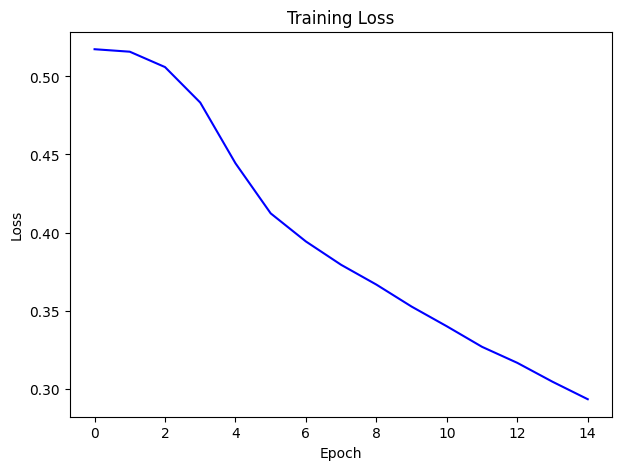

In [ ]:
#PLOT TRAINING LOSS
plt.figure(figsize=(7,5))
plt.plot(loss_history, color="blue")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
plt.savefig(loss_path, dpi=200, bbox_inches="tight")
plt.show()


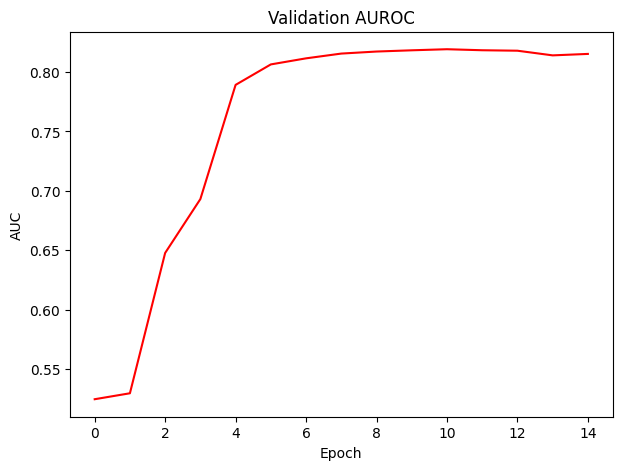

In [ ]:
#PLOT VALIDATION AUROC
plt.figure(figsize=(7,5))
plt.plot(val_auc_history, color="red")
plt.title("Validation AUROC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(False)
plt.savefig(auc_path, dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
from google.colab import files

files.download("/content/figures/training_loss.png")
files.download("/content/figures/validation_auc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t)
    probs_test = F.softmax(logits_test, dim=1)[:,1].cpu().numpy()
    test_auc = roc_auc_score(y_test_t.cpu().numpy(), probs_test)

test_auc


np.float64(0.810380846884856)